In [2]:
# Analysis the entropy of with the gamma
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

%matplotlib inline

# Calculate the entropy of an image
def entropy(img):
    if img.ndim > 2:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    # Get the pdf (histogram)
    p = np.zeros(256)
    for i in range(256):
        p[i] = np.sum(gray[:]==i).astype(float)/(gray.shape[0]*gray.shape[1])
    
    # Compute the entropy
    entropy = 0.0
    for i in range(256):
        if p[i]>0:
            entropy -= p[i]*np.log(p[i])
    return entropy

# our equ.(7), predict the entropy when we applied gamma trans to the PDF
def entropy_gamma(img, gamma):
    if img.ndim > 2:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = img
        
    # Get the pdf (histogram) of the original image
    p = np.zeros(256)
    for i in range(256):
        p[i] = np.sum(gray[:]==i).astype(float)/(gray.shape[0]*gray.shape[1])
    
    # Compute the entropy after distortion with gamma
    entropy = 0.0
    for i in range(256):
        if p[i]>0:
            entropy -= p[i]*np.log(p[i]*((i+0.5)/256)**(1-gamma)/gamma)
    return entropy

# AGT-ME method, infer a better gamma
def agt(img,gamma0):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    n_img  = (gray+0.5)/256.0
    delta_gamma = -1.0/np.mean(np.log(n_img)) 
    return delta_gamma*gamma0

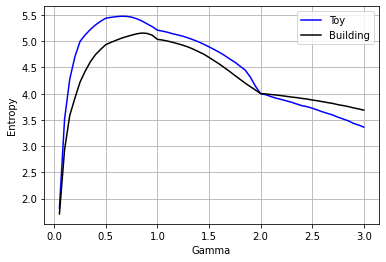

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
list_gamma,list_entropies = [],[]
list_agts, list_images = [],[]
paths=["../images/camera/car","../images/camera/buildings"]
for path in paths:
    names = os.listdir(path)
    gammas, images = [], []
    entropies, agts = [],[]
    # for i in range(10,30):
    # for i in range(5,30):
    for i in range(1,61):

        img = cv2.imread(path+"/"+str(i)+"image.bmp")
        gammas.append(0.05*i)
        images.append(img)
        entropies.append(entropy(img))
        agts.append(agt(img, 0.05*i))
    #     break
    list_gamma.append(np.array(gammas))
    list_entropies.append(np.array(entropies))
    list_agts.append(np.array(agts))
    list_images.append(images)
    
fig = plt.figure()
plt.plot(list_gamma[0],list_entropies[0],'b-',label="Toy")
plt.plot(list_gamma[1],list_entropies[1],'k-',label="Building")

plt.xlabel("Gamma")
plt.ylabel("Entropy")
plt.grid()
plt.legend()

# plt.figure()
# plt.plot(list_gamma[0],list_agts[0],'b-',label="Toy")
# plt.plot(list_gamma[1],list_agts[1],'k--',label="Building")
# plt.xlabel("Gamma")
# plt.ylabel("AGT estimation")
# plt.grid()
# plt.legend()

plt.show()
fig.savefig("Fig1_b.eps")

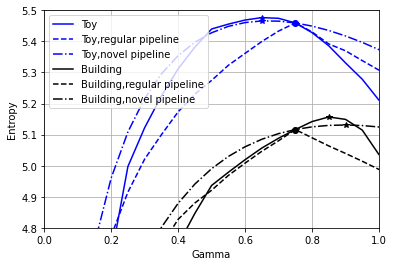

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [4]:
gamma0 = 0.75
index = np.round(gamma0/0.05).astype(np.int)-1
images_g1 = [list_images[0][index],list_images[1][index]]


list_entropies_prediction1 = []
list_entropies_prediction2 = []

for img in images_g1:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    entropies = []
    for i in range(1,61):
        gamma = 0.05*i/gamma0
        temp_img = np.round(255.0*(img/255.0)**gamma).astype(np.uint8)
        entropies.append(entropy(temp_img))
    list_entropies_prediction1.append(np.array(entropies))

for img in images_g1:
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    entropies = []
    for i in range(1,61):
        gamma = 0.05*i/gamma0
        entropies.append(entropy_gamma(img,gamma))
    list_entropies_prediction2.append(np.array(entropies))
    

fig = plt.figure()
lists = [list_entropies[0],list_entropies_prediction1[0],list_entropies_prediction2[0],
         list_entropies[1],list_entropies_prediction1[1],list_entropies_prediction2[1]]
name_lists = ["Toy","Toy,regular pipeline","Toy,novel pipeline",
              "Building","Building,regular pipeline","Building,novel pipeline"]
style_lists = ["b-","b--","b-.",
               "k-","k--","k-."]
for label, lst, style in zip(name_lists,lists,style_lists):
    plt.plot(list_gamma[0],lst,style,label=label)
    max_index = lst.argmax()
    plt.plot(list_gamma[0][max_index],lst[max_index],style[0]+"*")
    
plt.plot(list_gamma[0][index],list_entropies[0][index],'bo')
plt.plot(list_gamma[0][index],list_entropies[1][index],'ko')

plt.xlabel("Gamma")
plt.ylabel("Entropy")
plt.xlim(0.0,1.0)
plt.ylim(4.8,5.5)
plt.grid()
plt.legend()
plt.show()
fig.savefig("Fig1_c.eps")

In [5]:
for i in range(2):
    for j in range(1,61):
        cv2.putText(list_images[i][j-1],'G=%.2f' % (j*0.05), (0, 50), cv2.FONT_HERSHEY_COMPLEX, 2.0, (255, 0, 0), 5)

toy_image = list_images[0][0]
building_image = list_images[1][0]
for i in [0.5,1.0,1.5,2.0,2.5,3.0]:
    toy_image = np.concatenate((toy_image,np.zeros((480,10,3))+255),axis=1)
    building_image = np.concatenate((building_image,np.zeros((480,10,3))+255),axis=1)
    toy_image = np.concatenate((toy_image, list_images[0][int(i/0.05)-1]),axis=1)
    building_image = np.concatenate((building_image, list_images[1][int(i/0.05)-1]),axis=1)

# cv2.imwrite("toy.png", toy_image)
# cv2.imwrite("building.png", building_image)

image = np.concatenate((toy_image,np.zeros((10,toy_image.shape[1],3))+255),axis=0)
image = np.concatenate((image,building_image),axis=0)
cv2.imwrite("Fig1_a.png", image)
os.system("convert Fig1_a.png Fig1_a.eps")
os.system("rm ./Fig1_a.png")

0